# Module composition

Given our co-acting gene modules, we will now calculate the composition of those modules - are modules predominantly core, predominantly accessory or mixed.

To label modules we will use the [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) which is used to determine whether there is a significant association between two categorical variables in a contingency table (i.e two classifications of the data). Fisher’s exact test is used to determine if there is an association between the two classifications. In our case our classification are: whether a gene is core or accessory and whether the gene is inside a given module or outside. In other words, we want to determine if there is a statistically significant association between gene group and our given module. To do this we compare the ratio of core vs accessory genes within a given module are significantly different to the ratio of core vs accessory outside that module.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from core_acc_modules import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"

### Import module memberships

In [3]:
# Import module memberships
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", index_col=0, header=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", index_col=0, header=0)

In [4]:
pao1_membership.head()

,module id
PA0001,415
PA0002,573
PA0003,92
PA0004,567
PA0005,0


In [5]:
pa14_membership.head()

,module id
PA14_55610,3
PA14_55600,16
PA14_55590,602
PA14_55580,431
PA14_55570,46


### Map core/accessory labels to genes

In [6]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [7]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 534


In [8]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

### Fisher's exact test

In [9]:
# Get list of modules ids
pao1_module_ids = pao1_membership["module id"].unique()
pa14_module_ids = pa14_membership["module id"].unique()

In [10]:
pao1_gene_group_composition = pd.DataFrame(
    index=pao1_module_ids,
    columns=["num core", "num acc", "odds ratio", "p-value", "module label"],
)
pa14_gene_group_composition = pd.DataFrame(
    index=pa14_module_ids,
    columns=["num core", "num acc", "odds ratio", "p-value", "module label"],
)

In [11]:
pao1_gene_group_composition.head()

,num core,num acc,odds ratio,p-value,module label
415,NaN,NaN,NaN,NaN,NaN
573,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN
567,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN


In [12]:
def label_modules(
    module_ids_list,
    membership_df,
    core_genes_list,
    acc_genes_list,
    mult_test_correction,
    out_df,
):
    all_genes = list(membership_df.index)

    for module_id in module_ids_list:
        # Find genes in module and outside module
        genes_in_module = list(
            membership_df[membership_df["module id"] == module_id].index
        )
        genes_outside_module = list(set(all_genes).difference(genes_in_module))

        # Get core and accessory in module
        core_genes_in_module = [
            gene for gene in genes_in_module if gene in core_genes_list
        ]
        acc_genes_in_module = [
            gene for gene in genes_in_module if gene in acc_genes_list
        ]

        # Get core and accessory genes outside of module
        core_genes_outside_module = [
            gene for gene in genes_outside_module if gene in core_genes_list
        ]
        acc_genes_outside_module = [
            gene for gene in genes_outside_module if gene in acc_genes_list
        ]

        # Check
        assert len(all_genes) == len(core_genes_in_module) + len(
            acc_genes_in_module
        ) + len(core_genes_outside_module) + len(acc_genes_outside_module)
        assert len(genes_in_module) == len(core_genes_in_module) + len(
            acc_genes_in_module
        )

        # Make contingency table
        # -----|inside module|outside module
        # core | # genes     | # genes
        # acc  | # genes     | # genes
        observed_contingency_table = np.array(
            [
                [len(core_genes_in_module), len(core_genes_outside_module)],
                [len(acc_genes_in_module), len(acc_genes_outside_module)],
            ]
        )

        # Add 1 to avoid inf
        observed_contingency_table = observed_contingency_table + 1

        # H0: The probability that the gene is core is the same
        # whether or not you're in the module or outside
        # H1: The probability that a gene is core is higher or lower inside the module
        # than outside the module
        odds_ratio, pval = scipy.stats.fisher_exact(observed_contingency_table)

        # If using two separate one-sided tests
        # odds_ratio, pval_greater = scipy.stats.fisher_exact(
        #    observed_contingency_table, alternative="greater"
        # )
        # odds_ratio, pval_less = scipy.stats.fisher_exact(
        #    observed_contingency_table, alternative="less"
        # )

        # Fill in df
        out_df.loc[module_id, "num core in module"] = len(core_genes_in_module)
        out_df.loc[module_id, "num acc in module"] = len(acc_genes_in_module)
        out_df.loc[module_id, "num core outside module"] = len(
            core_genes_outside_module
        )
        out_df.loc[module_id, "num acc outside module"] = len(acc_genes_outside_module)
        out_df.loc[module_id, "odds ratio"] = odds_ratio
        out_df.loc[module_id, "p-value"] = pval

        # Given the small sizes of the modules I think this is why
        # most of the findings are not significant

        # Bonferrroni corrected p-value
        if mult_test_correction == "bonferroni":
            if odds_ratio > 1 and pval < 0.05 / len(all_genes):
                out_df.loc[module_id, "module label"] = "mostly core"
            elif odds_ratio < 1 and pval < 0.05 / len(all_genes):
                out_df.loc[module_id, "module label"] = "mostly accessory"
            else:
                out_df.loc[module_id, "module label"] = "mixed"

        # If using two separate one-sided tests
        # if odds_ratio > 1 and pval_greater < 0.05/len(all_genes):
        #    out_df.loc[module_id, "module label"] = "mostly core"
        # elif odds_ratio < 1 and pval_less < 0.05/len(all_genes):
        #    out_df.loc[module_id, "module label"] = "mostly accessory"
        # else:
        #    out_df.loc[module_id, "module label"] = "mixed"

    # FDR multiple testing correction with FDR
    if mult_test_correction == "fdr":
        sign, cpval, alphacSidak, alphacBonferroni = multipletests(
            out_df["p-value"], alpha=0.05, method="fdr_bh"
        )

        # Add columns
        out_df["significant"] = sign
        out_df["FDR corrected p-value"] = cpval

        # Label modules
        out_df["module label"] = "mixed"
        out_df.loc[
            (out_df["odds ratio"] > 1) & (out_df["significant"] == True), "module label"
        ] = "mostly core"
        out_df.loc[
            (out_df["odds ratio"] < 1) & (out_df["significant"] == True), "module label"
        ] = "mostly accessory"

    return out_df

In [13]:
%%time
# Get labels for PAO1 compendium
pao1_module_labels = label_modules(
    pao1_module_ids,
    pao1_membership,
    pao1_core,
    pao1_acc,
    "fdr",
    pao1_gene_group_composition,
)

CPU times: user 1min 57s, sys: 3.75 ms, total: 1min 57s
Wall time: 1min 57s


In [14]:
%%time
# Get labels of PA14 compendium
pa14_module_labels = label_modules(
    pa14_module_ids,
    pa14_membership,
    pa14_core,
    pa14_acc,
    "fdr",
    pa14_gene_group_composition,
)

CPU times: user 2min 31s, sys: 12 ms, total: 2min 31s
Wall time: 2min 31s


In [15]:
pao1_module_labels.head()

,num core,num acc,odds ratio,p-value,module label,num core in module,num acc in module,num core outside module,num acc outside module,significant,FDR corrected p-value
415,NaN,NaN,0.493271,0.407427,mixed,12.0,0.0,5349.0,202.0,False,0.47137
573,NaN,NaN,0.417227,0.36138,mixed,10.0,0.0,5351.0,202.0,False,0.46881
92,NaN,NaN,0.26531,0.258332,mixed,6.0,0.0,5355.0,202.0,False,0.46881
567,NaN,NaN,0.455242,0.384832,mixed,11.0,0.0,5350.0,202.0,False,0.46881
0,NaN,NaN,0.493271,0.407427,mixed,12.0,0.0,5349.0,202.0,False,0.47137


In [16]:
pa14_module_labels.head()

,num core,num acc,odds ratio,p-value,module label,num core in module,num acc in module,num core outside module,num acc outside module,significant,FDR corrected p-value
3,NaN,NaN,0.749439,0.66347,mixed,14.0,1.0,5343.0,533.0,False,1
16,NaN,NaN,2.10472,0.715695,mixed,20.0,0.0,5337.0,534.0,False,1
602,NaN,NaN,0.648416,0.34555,mixed,25.0,3.0,5332.0,531.0,False,1
431,NaN,NaN,1.30097,1,mixed,12.0,0.0,5345.0,534.0,False,1
46,NaN,NaN,0.349215,0.194189,mixed,6.0,1.0,5351.0,533.0,False,1


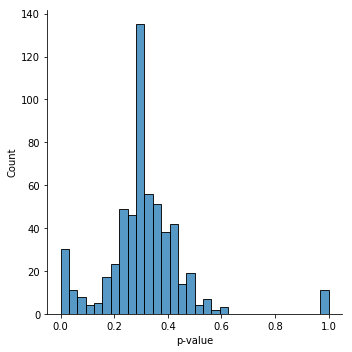

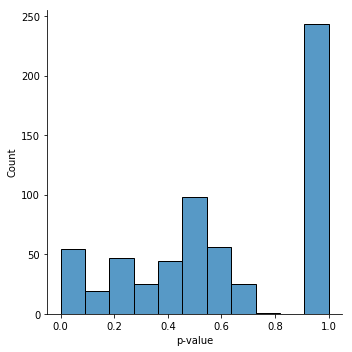

In [17]:
# Distribution of p-values
sns.displot(pao1_module_labels["p-value"])
sns.displot(pa14_module_labels["p-value"])

### Examine module composition

In [18]:
pao1_module_labels["module label"].value_counts()

mixed               557
mostly accessory     18
Name: module label, dtype: int64

In [19]:
pa14_module_labels["module label"].value_counts()

mixed               575
mostly accessory     37
Name: module label, dtype: int64

In [20]:
# Add size of modules to df
pao1_module_labels["size"] = pao1_membership["module id"].value_counts()
pa14_module_labels["size"] = pa14_membership["module id"].value_counts()

In [21]:
pao1_module_labels.head()

,num core,num acc,odds ratio,p-value,module label,num core in module,num acc in module,num core outside module,num acc outside module,significant,FDR corrected p-value,size
415,NaN,NaN,0.493271,0.407427,mixed,12.0,0.0,5349.0,202.0,False,0.47137,12
573,NaN,NaN,0.417227,0.36138,mixed,10.0,0.0,5351.0,202.0,False,0.46881,10
92,NaN,NaN,0.26531,0.258332,mixed,6.0,0.0,5355.0,202.0,False,0.46881,6
567,NaN,NaN,0.455242,0.384832,mixed,11.0,0.0,5350.0,202.0,False,0.46881,11
0,NaN,NaN,0.493271,0.407427,mixed,12.0,0.0,5349.0,202.0,False,0.47137,12


In [22]:
pa14_module_labels.head()

,num core,num acc,odds ratio,p-value,module label,num core in module,num acc in module,num core outside module,num acc outside module,significant,FDR corrected p-value,size
3,NaN,NaN,0.749439,0.66347,mixed,14.0,1.0,5343.0,533.0,False,1,15
16,NaN,NaN,2.10472,0.715695,mixed,20.0,0.0,5337.0,534.0,False,1,20
602,NaN,NaN,0.648416,0.34555,mixed,25.0,3.0,5332.0,531.0,False,1,28
431,NaN,NaN,1.30097,1,mixed,12.0,0.0,5345.0,534.0,False,1,12
46,NaN,NaN,0.349215,0.194189,mixed,6.0,1.0,5351.0,533.0,False,1,7


Text(0.5, 1.0, 'Size distribution of PAO1 mostly core modules')

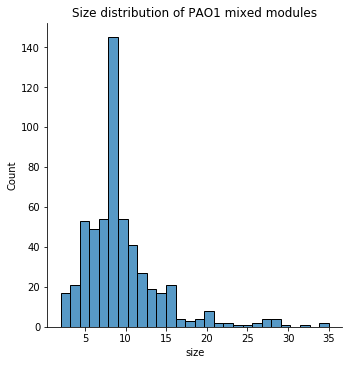

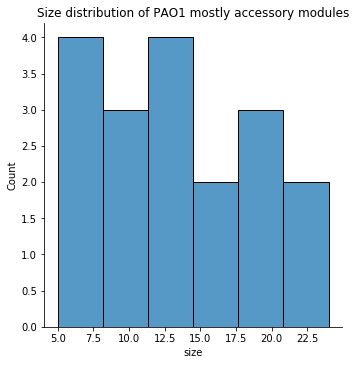

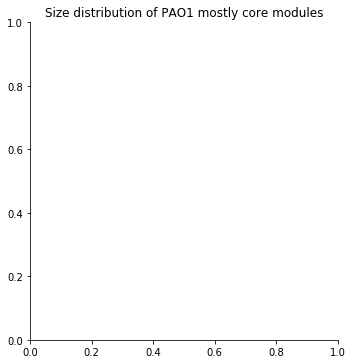

In [23]:
# Size distributions of PAO1 modules
f1 = sns.displot(
    pao1_module_labels.loc[pao1_module_labels["module label"] == "mixed", "size"]
)
plt.title("Size distribution of PAO1 mixed modules")

f2 = sns.displot(
    pao1_module_labels.loc[
        pao1_module_labels["module label"] == "mostly accessory", "size"
    ]
)
plt.title("Size distribution of PAO1 mostly accessory modules")

f3 = sns.displot(
    pao1_module_labels.loc[pao1_module_labels["module label"] == "mostly core", "size"]
)
plt.title("Size distribution of PAO1 mostly core modules")

Text(0.5, 1.0, 'Size distribution of PA14 mostly core modules')

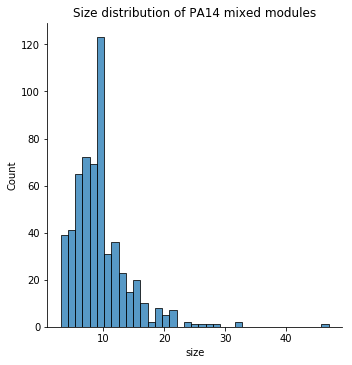

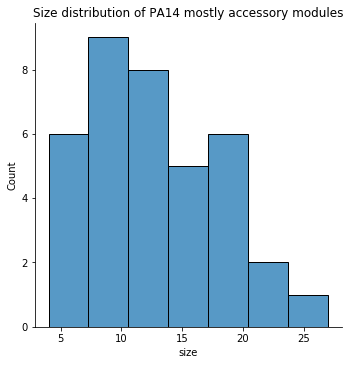

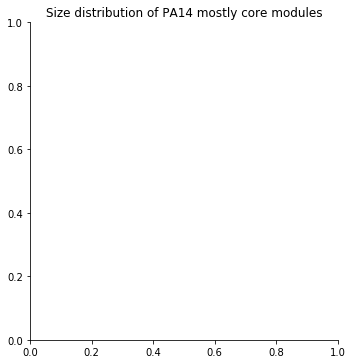

In [24]:
# Size distributions of PA14 moduels
g1 = sns.displot(
    pa14_module_labels.loc[pa14_module_labels["module label"] == "mixed", "size"]
)
plt.title("Size distribution of PA14 mixed modules")

g2 = sns.displot(
    pa14_module_labels.loc[
        pa14_module_labels["module label"] == "mostly accessory", "size"
    ]
)
plt.title("Size distribution of PA14 mostly accessory modules")

g3 = sns.displot(
    pa14_module_labels.loc[pa14_module_labels["module label"] == "mostly core", "size"]
)
plt.title("Size distribution of PA14 mostly core modules")

In [25]:
# Save
pao1_module_labels.to_csv(
    os.path.join(paths.LOCAL_DATA_DIR, f"pao1_gene_module_labels_{method}.tsv"),
    sep="\t",
)
pa14_module_labels.to_csv(
    os.path.join(paths.LOCAL_DATA_DIR, f"pa14_gene_module_labels_{method}.tsv"),
    sep="\t",
)

In [26]:
# TO DO: Compare the composition across partitions
# Save the matrix that maps module id to module label per partition
# In another notebook look through module labels per partition
# Calculate consistency of labeling using ARI for each pair of partitions

**Takeaway:**
* Most modules are mixed, some are mostly accessory. Only PA14 compendium have some mostly core modules
* PAO1, PA14 mixed and mostly accessory modules have similar sizes